In [1]:
import pickle
import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir("../..")
os.environ['NUMEXPR_NUM_THREADS'] = '10'

In [2]:
import pandas as pd
import numpy as np
# import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from category_encoders import TargetEncoder
# import shap
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (0)
libgomp: Invalid value for environment variable OMP_NUM_THREADS
/home/jovyan/anaconda3/envs/recsys/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read dataset characteristics
data = pd.read_csv(os.path.join("results", "datasets_statistics", "statistics_df.csv"), index_col=0)

In [5]:
metrics = pd.read_csv(os.path.join("results", "aggregation", "agg_metrics.csv"), index_col=False)

In [7]:
metrics = metrics[metrics.Metric == 'ndcg']

In [8]:
metrics = metrics[metrics['k']== 10]
metrics.drop(columns=['k', 'Metric'], inplace=True)

In [9]:
metrics = metrics[~((metrics['Method'] == 'most_popular') | (metrics['Method'] == 'random'))]


In [10]:
data.reset_index(inplace=True)
data.rename(columns={'index': 'Dataset'}, inplace=True)

In [11]:
data.keys()

Index(['Dataset', 'Nu', 'Ni', 'Nr', 'SpaceSize', 'Shape', 'Density', 'Rpu',
       'Rpi', 'Ginii', 'Giniu', 'APB', 'StPB', 'SkPB', 'KuPB', 'LTavg',
       'LTstd', 'LTsk', 'LTku'],
      dtype='object')

In [12]:
X = data.merge(metrics, on='Dataset')

In [129]:
encoder = TargetEncoder()
X['RecSysMethod'] = encoder.fit_transform(X['Method'], X['Value'])

In [130]:
X = X[X.columns.difference(['FracInteractionsVal', 'FracInteractionsTest',
       'FracPassiveUsersVal', 'FracPassiveUsersTest', 'FracPassiveItemsVal',
       'FracPassiveItemsTest',])]

In [131]:
X_train_full = X[X.columns.difference(['Value','Dataset', 'Method',])].astype(float)
y_train_full = X['Value']

In [15]:
# Define a mapping dictionary
mapping_dict = {
    "recbole_ItemKNN": "ItemKNN",
    "recbole_EASE": "EASE",
    "recbole_MultiVAE": "MultiVAE",
    "recbole_LightGCN": "LightGCN",
    "recbole_LightGCL": "LightGCL",
    "implicit_bpr": "BPR",
    "implicit_als": "ALS",
    "lightfm": "LightFM",
    "recbole_SLIMElastic": "SLIM",
    "most_popular": "MostPop",
    "random": "Random",
}

# Use the .replace() method to update the values in the 'Method' column
X['Method'] = X['Method'].replace(mapping_dict)

In [16]:
X.to_csv(os.path.join("results", "datasets_statistics", "Datafeatures_and_metrics.csv"), index=False)

In [141]:
# Split into training and testing sets
# Split by dataset_name to ensure entire groups are in train or test, not split between them
train_datasets, test_datasets = train_test_split(X['Dataset'].unique(), test_size=0.1, random_state=19)

train_df = X[X['Dataset'].isin(train_datasets)]
test_df = X[X['Dataset'].isin(test_datasets)]
X_train = train_df[train_df.columns.difference(['Dataset', 'Method',])].astype(float)
y_train = X_train.pop('Value')
X_test = test_df[test_df.columns.difference(['Dataset', 'Method',])].astype(float)
y_test = X_test.pop('Value')


In [142]:
test_df.Dataset.unique()

array(['kuairec_small', 'movielens_10m', 'sber_smm'], dtype=object)

In [148]:
def objective(trial):
    # Define search space for hyperparameters
    param = {
        'objective': 'reg:squarederror',
        'verbosity': 0,
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 5, 50),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
        
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    return r2


In [149]:
study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=50)

# Results
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Train the model with the best hyperparameters
best_params = trial.params
model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', verbosity=0)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

[I 2023-10-12 13:37:07,751] A new study created in memory with name: no-name-82270da1-6458-4060-a2fa-f9a3e2549937
[I 2023-10-12 13:37:11,930] Trial 0 finished with value: 0.08538150891149832 and parameters: {'booster': 'gbtree', 'lambda': 5.4922611284923694e-05, 'alpha': 2.6049583722240917e-05, 'learning_rate': 0.02482454796415015, 'n_estimators': 16, 'max_depth': 4, 'subsample': 0.933326247011347, 'colsample_bytree': 0.7447359482955982, 'min_child_weight': 2}. Best is trial 0 with value: 0.08538150891149832.
[I 2023-10-12 13:37:17,288] Trial 1 finished with value: -0.18181410204727944 and parameters: {'booster': 'gbtree', 'lambda': 8.407073583817614e-05, 'alpha': 1.7883773599935354e-06, 'learning_rate': 0.0004839151912640868, 'n_estimators': 20, 'max_depth': 5, 'subsample': 0.3447699915579098, 'colsample_bytree': 0.3679166238574736, 'min_child_weight': 10}. Best is trial 0 with value: 0.08538150891149832.
[I 2023-10-12 13:37:25,843] Trial 2 finished with value: -0.14845631361025724 an

Number of finished trials:  50
Best trial:
Value:  0.47085841963640485
Params: 
    booster: gbtree
    lambda: 0.0003901713564732346
    alpha: 0.0023780141812504044
    learning_rate: 0.08690656695046181
    n_estimators: 48
    max_depth: 6
    subsample: 0.9760200134841764
    colsample_bytree: 0.8147239419826666
    min_child_weight: 1


In [150]:
best_params

{'booster': 'gbtree',
 'lambda': 0.0003901713564732346,
 'alpha': 0.0023780141812504044,
 'learning_rate': 0.08690656695046181,
 'n_estimators': 48,
 'max_depth': 6,
 'subsample': 0.9760200134841764,
 'colsample_bytree': 0.8147239419826666,
 'min_child_weight': 1}

In [151]:
# Calculate the R2 score
r2 = r2_score(y_test, y_pred)

print("R-squared (R2) Score:", r2)

R-squared (R2) Score: 0.47085841963640485


In [152]:
import scipy.stats
# Calculate Mean Spearman Rank Correlation Coefficient:
spearman_corr_list = []
num_of_methods = X['Method'].nunique()
for i in range(len(y_pred) // num_of_methods):
    print 
    spearman_corr, _ = scipy.stats.spearmanr(y_test[i*num_of_methods:(i+1)*num_of_methods], y_pred[i*num_of_methods:(i+1)*num_of_methods])
    spearman_corr_list.append(spearman_corr)
    
print("Mean Spearman Rank Correlation Coefficient:", np.mean(spearman_corr_list))

Mean Spearman Rank Correlation Coefficient: 0.6428571428571429


In [153]:
# Use SHAP to interpret the model
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:48:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


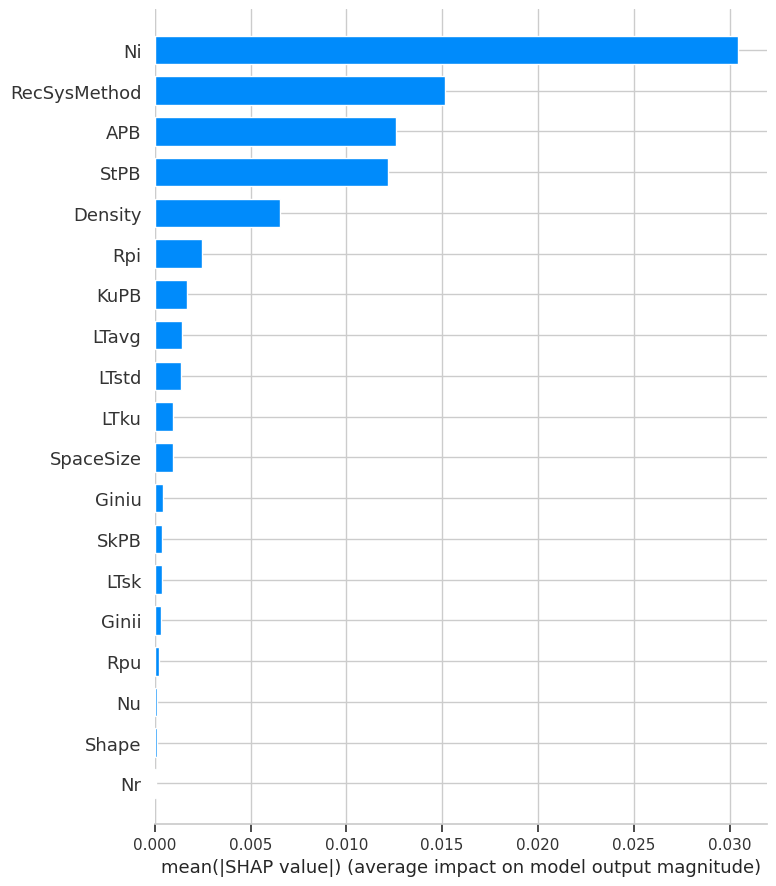

In [154]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [155]:
import dtreeviz
viz_rmodel = dtreeviz.model(model=model, tree_index=1, 
                            X_train=X_train, 
                            y_train=y_train, 
                            feature_names=list(X_train.keys()), 
                            target_name='nDCG@10')


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

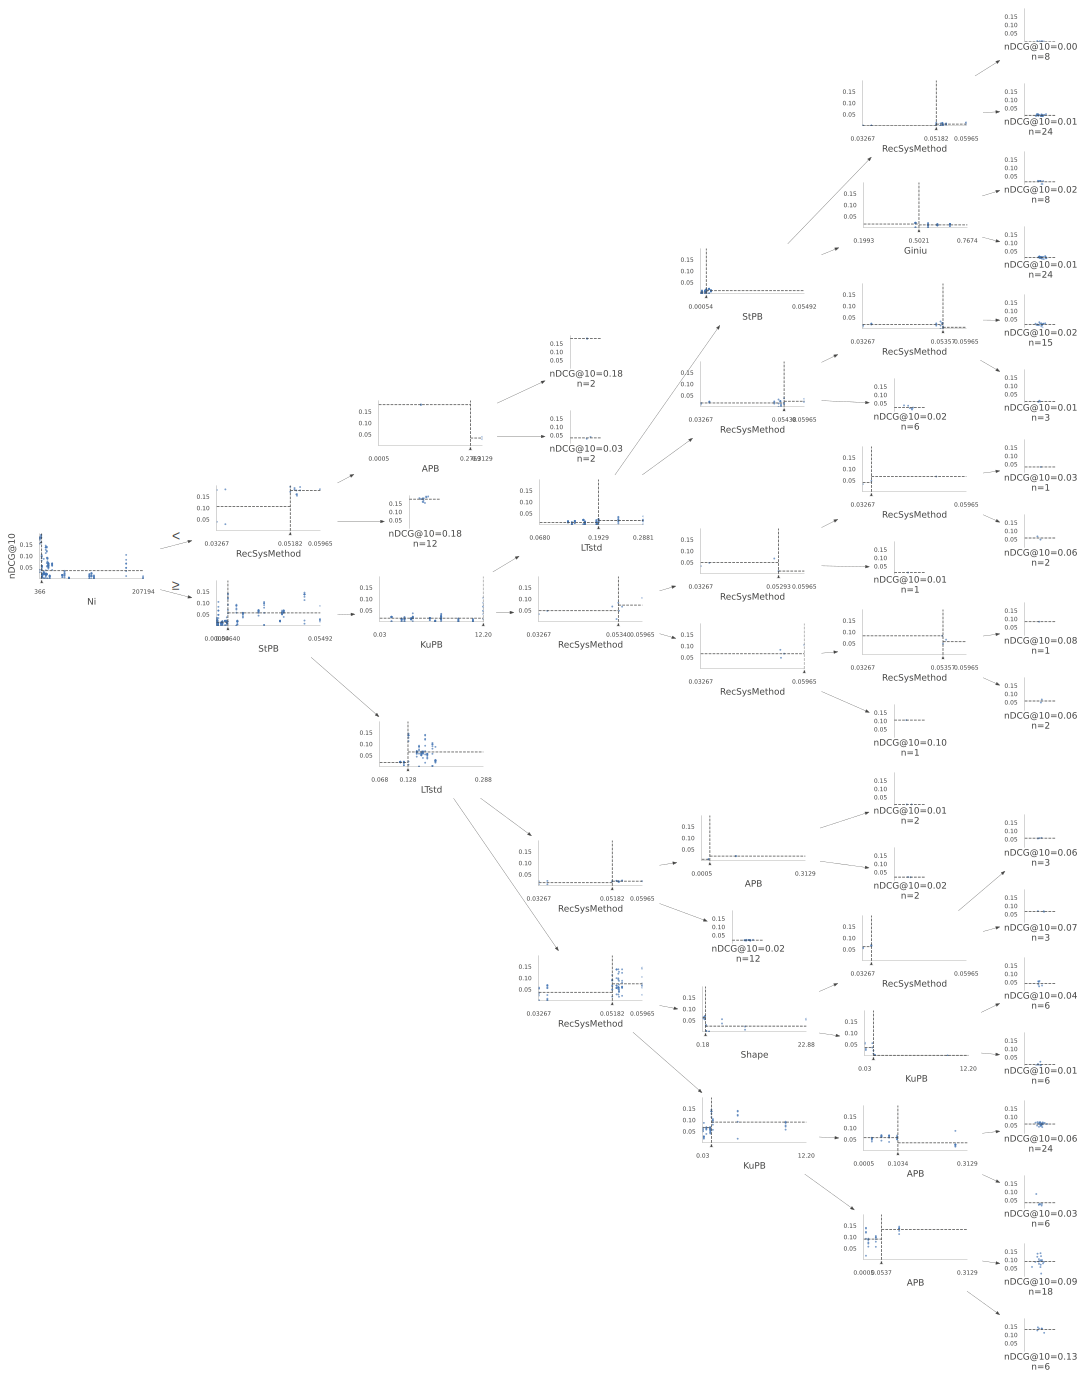

In [156]:
viz_rmodel.view(orientation="LR")

In [164]:
# Initialize variables to store SHAP values and feature importances
shap_values_list = []
feature_importance_list = []
spearman_overall_list = []
r2_overall_list = []
# Iterate through different random_state values
for random_state in range(100):
    # Split into training and testing sets
    train_datasets_rand, test_datasets_rand = train_test_split(X['Dataset'].unique(), test_size=0.15, random_state=random_state)

    train_df_rand = X[X['Dataset'].isin(train_datasets_rand)]
    test_df_rand = X[X['Dataset'].isin(test_datasets_rand)]
    
    X_train_rand = train_df_rand[train_df_rand.columns.difference(['Dataset', 'Method',])].astype(float)
    y_train_rand = X_train_rand.pop('Value')
    X_test_rand = test_df_rand[test_df_rand.columns.difference(['Dataset', 'Method',])].astype(float)
    y_test_rand = X_test_rand.pop('Value')
    
    # Train an XGBoost regressor
    model_rand = xgb.XGBRegressor(**best_params, objective ='reg:squarederror', verbosity=0)
    model_rand.fit(X_train_rand, y_train_rand)
    
    # Predict
    y_pred_rand = model_rand.predict(X_test_rand)
    
    # Calculate the R2 score for this split
    r2 = r2_score(y_test_rand, y_pred_rand)
    print(f"Random State {random_state}: R-squared (R2) Score: {r2}")
    spearman_corr_list = []
    num_of_methods = X['Method'].nunique()
    for i in range(len(y_pred_rand) // num_of_methods):
        spearman_corr, _ = scipy.stats.spearmanr(y_test_rand[i*num_of_methods:(i+1)*num_of_methods], y_pred_rand[i*num_of_methods:(i+1)*num_of_methods])
        spearman_corr_list.append(spearman_corr)
        
    print(f"Random State {random_state}: Mean Spearman Rank Correlation Coefficient: {np.mean(spearman_corr_list)}")
    spearman_overall_list.append(np.mean(spearman_corr_list))
    r2_overall_list.append(r2)
    # Use SHAP to interpret the model
    explainer = shap.Explainer(model_rand)
    shap_values = explainer(X_test_rand)
    shap_values_list.append(shap_values)
    
    # Calculate and store mean SHAP values as feature importances
    mean_shap_values = np.abs(shap_values.values).mean(axis=0)
    feature_importance = pd.Series(mean_shap_values, index=X_test_rand.columns).sort_values(ascending=False)
    feature_importance_list.append(feature_importance)


Random State 0: R-squared (R2) Score: 0.08773822696662448
Random State 0: Mean Spearman Rank Correlation Coefficient: 0.46190476190476193


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 1: R-squared (R2) Score: 0.16668453028161645
Random State 1: Mean Spearman Rank Correlation Coefficient: 0.3666666666666667


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 2: R-squared (R2) Score: -13.188550516201452
Random State 2: Mean Spearman Rank Correlation Coefficient: 0.45714285714285713


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:46:59] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 3: R-squared (R2) Score: -0.01312835865316142
Random State 3: Mean Spearman Rank Correlation Coefficient: 0.5142857142857143


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:18] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 4: R-squared (R2) Score: 0.4528483814379921
Random State 4: Mean Spearman Rank Correlation Coefficient: 0.6523809523809525


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 5: R-squared (R2) Score: 0.45521910058850334
Random State 5: Mean Spearman Rank Correlation Coefficient: 0.34285714285714286


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:47:57] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 6: R-squared (R2) Score: -6.260399293607988
Random State 6: Mean Spearman Rank Correlation Coefficient: 0.4428571428571429


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 7: R-squared (R2) Score: -0.08465746751011549
Random State 7: Mean Spearman Rank Correlation Coefficient: 0.5142857142857145


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 8: R-squared (R2) Score: -6.26087829821077
Random State 8: Mean Spearman Rank Correlation Coefficient: 0.31428571428571433


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:48:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 9: R-squared (R2) Score: 0.21633677710884092
Random State 9: Mean Spearman Rank Correlation Coefficient: 0.6761904761904762


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:49:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 10: R-squared (R2) Score: -0.8134851664960832
Random State 10: Mean Spearman Rank Correlation Coefficient: 0.6095238095238096


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:49:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 11: R-squared (R2) Score: 0.2325656985861141
Random State 11: Mean Spearman Rank Correlation Coefficient: 0.27142857142857146


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:49:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 12: R-squared (R2) Score: 0.46271957166818944
Random State 12: Mean Spearman Rank Correlation Coefficient: 0.523809523809524


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 13: R-squared (R2) Score: -0.14374892020136887
Random State 13: Mean Spearman Rank Correlation Coefficient: 0.3285714285714286


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 14: R-squared (R2) Score: 0.4796898265680051
Random State 14: Mean Spearman Rank Correlation Coefficient: 0.6666666666666667


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:50:49] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 15: R-squared (R2) Score: 0.5968343748603866
Random State 15: Mean Spearman Rank Correlation Coefficient: 0.5571428571428572


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 16: R-squared (R2) Score: -0.8606691997992162
Random State 16: Mean Spearman Rank Correlation Coefficient: 0.4333333333333334


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 17: R-squared (R2) Score: 0.46656917345685656
Random State 17: Mean Spearman Rank Correlation Coefficient: 0.6602245165246423


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:51:46] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 18: R-squared (R2) Score: -0.18580567708828544
Random State 18: Mean Spearman Rank Correlation Coefficient: 0.6476190476190478


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 19: R-squared (R2) Score: -0.08011824979395477
Random State 19: Mean Spearman Rank Correlation Coefficient: 0.522215079286649


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 20: R-squared (R2) Score: -0.7221040897603159
Random State 20: Mean Spearman Rank Correlation Coefficient: 0.34761904761904766


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:52:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 21: R-squared (R2) Score: -0.3653597877865009
Random State 21: Mean Spearman Rank Correlation Coefficient: 0.5428571428571429


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 22: R-squared (R2) Score: -0.4643938208013929
Random State 22: Mean Spearman Rank Correlation Coefficient: 0.5722865800010197


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:19] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 23: R-squared (R2) Score: -0.1401301602670566
Random State 23: Mean Spearman Rank Correlation Coefficient: 0.6523809523809525


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 24: R-squared (R2) Score: -0.826969782411066
Random State 24: Mean Spearman Rank Correlation Coefficient: 0.48571428571428577


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:53:56] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 25: R-squared (R2) Score: -0.3647638288796844
Random State 25: Mean Spearman Rank Correlation Coefficient: 0.3571428571428571


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:14] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 26: R-squared (R2) Score: 0.13706946575987244
Random State 26: Mean Spearman Rank Correlation Coefficient: 0.5238095238095238


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 27: R-squared (R2) Score: -15.807381623403835
Random State 27: Mean Spearman Rank Correlation Coefficient: 0.7333333333333334


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:54:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 28: R-squared (R2) Score: 0.0367874773636363
Random State 28: Mean Spearman Rank Correlation Coefficient: 0.47142857142857153


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 29: R-squared (R2) Score: -0.3869148047534636
Random State 29: Mean Spearman Rank Correlation Coefficient: 0.2714285714285715


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 30: R-squared (R2) Score: 0.3539720050536571
Random State 30: Mean Spearman Rank Correlation Coefficient: 0.4761904761904763


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:46] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 31: R-squared (R2) Score: 0.40744514742997884
Random State 31: Mean Spearman Rank Correlation Coefficient: 0.5795295381439958


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:56:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 32: R-squared (R2) Score: 0.27721202406103984
Random State 32: Mean Spearman Rank Correlation Coefficient: 0.6857142857142857


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:56:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 33: R-squared (R2) Score: -0.18427256536718084
Random State 33: Mean Spearman Rank Correlation Coefficient: 0.742857142857143


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:56:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 34: R-squared (R2) Score: -2.5914776889973794
Random State 34: Mean Spearman Rank Correlation Coefficient: 0.2904761904761905


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:56:59] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 35: R-squared (R2) Score: 0.23437078784938425
Random State 35: Mean Spearman Rank Correlation Coefficient: 0.5190476190476192


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:57:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 36: R-squared (R2) Score: 0.6283255894131565
Random State 36: Mean Spearman Rank Correlation Coefficient: 0.498176753191139


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:57:29] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 37: R-squared (R2) Score: -20.5190805820629
Random State 37: Mean Spearman Rank Correlation Coefficient: 0.6571428571428573


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:57:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 38: R-squared (R2) Score: -0.4258936490763814
Random State 38: Mean Spearman Rank Correlation Coefficient: 0.7666666666666667


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:58:06] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 39: R-squared (R2) Score: -3.299089974270359
Random State 39: Mean Spearman Rank Correlation Coefficient: 0.4428571428571429


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:58:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 40: R-squared (R2) Score: -0.2067375318924609
Random State 40: Mean Spearman Rank Correlation Coefficient: 0.5333333333333334


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:58:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 41: R-squared (R2) Score: 0.43429253241620225
Random State 41: Mean Spearman Rank Correlation Coefficient: 0.3571428571428572


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:59:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 42: R-squared (R2) Score: 0.6105069940564545
Random State 42: Mean Spearman Rank Correlation Coefficient: 0.4857142857142859


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:59:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 43: R-squared (R2) Score: -2.144054077822194
Random State 43: Mean Spearman Rank Correlation Coefficient: 0.523809523809524


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:59:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 44: R-squared (R2) Score: -1.5245717400115741
Random State 44: Mean Spearman Rank Correlation Coefficient: 0.30476190476190473


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:59:55] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 45: R-squared (R2) Score: -0.9400225852594453
Random State 45: Mean Spearman Rank Correlation Coefficient: 0.480952380952381


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:00:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 46: R-squared (R2) Score: 0.5633370971917449
Random State 46: Mean Spearman Rank Correlation Coefficient: 0.6761904761904763


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:00:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 47: R-squared (R2) Score: -6.0991805244102695
Random State 47: Mean Spearman Rank Correlation Coefficient: 0.2709709668565991


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:00:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 48: R-squared (R2) Score: 0.37101809460680113
Random State 48: Mean Spearman Rank Correlation Coefficient: 0.6761904761904762


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:01:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 49: R-squared (R2) Score: 0.5873527350123553
Random State 49: Mean Spearman Rank Correlation Coefficient: 0.6714285714285716


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:01:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 50: R-squared (R2) Score: 0.6967749988626852
Random State 50: Mean Spearman Rank Correlation Coefficient: 0.5190476190476191


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:01:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 51: R-squared (R2) Score: -5.676403946297231
Random State 51: Mean Spearman Rank Correlation Coefficient: 0.3095238095238096


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 52: R-squared (R2) Score: 0.5406078693743146
Random State 52: Mean Spearman Rank Correlation Coefficient: 0.5285714285714287


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 53: R-squared (R2) Score: -16.054023119295405
Random State 53: Mean Spearman Rank Correlation Coefficient: 0.44761904761904764


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 54: R-squared (R2) Score: 0.3268774571600199
Random State 54: Mean Spearman Rank Correlation Coefficient: 0.3333333333333334


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 55: R-squared (R2) Score: -0.10943453840954365
Random State 55: Mean Spearman Rank Correlation Coefficient: 0.3319104905249481


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 56: R-squared (R2) Score: 0.3487317290612787
Random State 56: Mean Spearman Rank Correlation Coefficient: 0.43809523809523815


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 57: R-squared (R2) Score: -1.059257913244061
Random State 57: Mean Spearman Rank Correlation Coefficient: 0.42857142857142866


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:46] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 58: R-squared (R2) Score: 0.1222142723420383
Random State 58: Mean Spearman Rank Correlation Coefficient: 0.6758586606746222


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 59: R-squared (R2) Score: -1.9781313146068369
Random State 59: Mean Spearman Rank Correlation Coefficient: 0.723809523809524


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 60: R-squared (R2) Score: 0.2153724917345856
Random State 60: Mean Spearman Rank Correlation Coefficient: 0.6190476190476192


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 61: R-squared (R2) Score: -7.992589912891626
Random State 61: Mean Spearman Rank Correlation Coefficient: 0.19523809523809524


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:59] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 62: R-squared (R2) Score: -0.48128553525221185
Random State 62: Mean Spearman Rank Correlation Coefficient: 0.2


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 63: R-squared (R2) Score: 0.386341869210998
Random State 63: Mean Spearman Rank Correlation Coefficient: 0.6952380952380952


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 64: R-squared (R2) Score: -0.5539034918670174
Random State 64: Mean Spearman Rank Correlation Coefficient: 0.5285714285714287


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 65: R-squared (R2) Score: 0.34133427944454775
Random State 65: Mean Spearman Rank Correlation Coefficient: 0.7285714285714286


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 66: R-squared (R2) Score: -0.3776694446342381
Random State 66: Mean Spearman Rank Correlation Coefficient: 0.6047619047619048


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 67: R-squared (R2) Score: -0.2860201610173949
Random State 67: Mean Spearman Rank Correlation Coefficient: 0.6169455408603037


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 68: R-squared (R2) Score: -6.193980398255444
Random State 68: Mean Spearman Rank Correlation Coefficient: 0.44761904761904764


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 69: R-squared (R2) Score: -0.1654800953138218
Random State 69: Mean Spearman Rank Correlation Coefficient: 0.4428571428571429


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 70: R-squared (R2) Score: 0.3031514611564027
Random State 70: Mean Spearman Rank Correlation Coefficient: 0.5904761904761905


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 71: R-squared (R2) Score: -0.42747054352323044
Random State 71: Mean Spearman Rank Correlation Coefficient: 0.4142857142857144


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:08:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 72: R-squared (R2) Score: 0.10137128857408095
Random State 72: Mean Spearman Rank Correlation Coefficient: 0.7380952380952381


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:08:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 73: R-squared (R2) Score: 0.004751014490987693
Random State 73: Mean Spearman Rank Correlation Coefficient: 0.6238095238095239


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:08:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 74: R-squared (R2) Score: -6.694254582367691
Random State 74: Mean Spearman Rank Correlation Coefficient: 0.5666666666666668


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:08:57] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 75: R-squared (R2) Score: -0.4181034350620809
Random State 75: Mean Spearman Rank Correlation Coefficient: 0.7523809523809525


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:15] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 76: R-squared (R2) Score: -0.21055483805234676
Random State 76: Mean Spearman Rank Correlation Coefficient: 0.5333333333333334


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 77: R-squared (R2) Score: -0.33323265789005996
Random State 77: Mean Spearman Rank Correlation Coefficient: 0.6380952380952382


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:52] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 78: R-squared (R2) Score: 0.5769636826899085
Random State 78: Mean Spearman Rank Correlation Coefficient: 0.580952380952381


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:10:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 79: R-squared (R2) Score: -0.22004895851524897
Random State 79: Mean Spearman Rank Correlation Coefficient: 0.5285714285714286


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:10:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 80: R-squared (R2) Score: -6.063192895273102
Random State 80: Mean Spearman Rank Correlation Coefficient: 0.20476190476190484


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:10:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 81: R-squared (R2) Score: -0.2617944739304512
Random State 81: Mean Spearman Rank Correlation Coefficient: 0.8238095238095239


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:11:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 82: R-squared (R2) Score: 0.6176569374198615
Random State 82: Mean Spearman Rank Correlation Coefficient: 0.5190476190476192


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:11:23] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 83: R-squared (R2) Score: 0.5659807996404492
Random State 83: Mean Spearman Rank Correlation Coefficient: 0.5476190476190477


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:11:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 84: R-squared (R2) Score: 0.3664305873038476
Random State 84: Mean Spearman Rank Correlation Coefficient: 0.7190476190476192


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:12:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 85: R-squared (R2) Score: 0.4206890119170934
Random State 85: Mean Spearman Rank Correlation Coefficient: 0.48571428571428565


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:12:18] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 86: R-squared (R2) Score: 0.30994289740494807
Random State 86: Mean Spearman Rank Correlation Coefficient: 0.7142857142857144


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:12:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 87: R-squared (R2) Score: -0.7881631252839432
Random State 87: Mean Spearman Rank Correlation Coefficient: 0.4142857142857144


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:12:55] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 88: R-squared (R2) Score: -1.5505742715031743
Random State 88: Mean Spearman Rank Correlation Coefficient: 0.5142857142857143


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:13:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 89: R-squared (R2) Score: 0.0034184506320585895
Random State 89: Mean Spearman Rank Correlation Coefficient: 0.6238095238095239


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:13:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 90: R-squared (R2) Score: -0.6402382710094241
Random State 90: Mean Spearman Rank Correlation Coefficient: 0.5904761904761905


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:13:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 91: R-squared (R2) Score: 0.2737805314463
Random State 91: Mean Spearman Rank Correlation Coefficient: 0.6857142857142857


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:14:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 92: R-squared (R2) Score: -0.1950108665176098
Random State 92: Mean Spearman Rank Correlation Coefficient: 0.45714285714285713


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:14:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 93: R-squared (R2) Score: 0.47899257355647273
Random State 93: Mean Spearman Rank Correlation Coefficient: 0.5571428571428572


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:14:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 94: R-squared (R2) Score: -0.040918291686091735
Random State 94: Mean Spearman Rank Correlation Coefficient: 0.580952380952381


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:15:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 95: R-squared (R2) Score: -0.1703827666047153
Random State 95: Mean Spearman Rank Correlation Coefficient: 0.46190476190476193


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:15:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 96: R-squared (R2) Score: -0.04513198062753321
Random State 96: Mean Spearman Rank Correlation Coefficient: 0.546139004239166


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:15:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 97: R-squared (R2) Score: 0.055833764804276376
Random State 97: Mean Spearman Rank Correlation Coefficient: 0.5380952380952382


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:15:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 98: R-squared (R2) Score: 0.3670860670103042
Random State 98: Mean Spearman Rank Correlation Coefficient: 0.4904761904761905


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:16:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 99: R-squared (R2) Score: -0.004483883389068577
Random State 99: Mean Spearman Rank Correlation Coefficient: 0.49523809523809526


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:16:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [168]:
np.mean(spearman_overall_list)

0.5231235236839832

In [169]:
np.mean(r2_overall_list)

-1.282123760301416

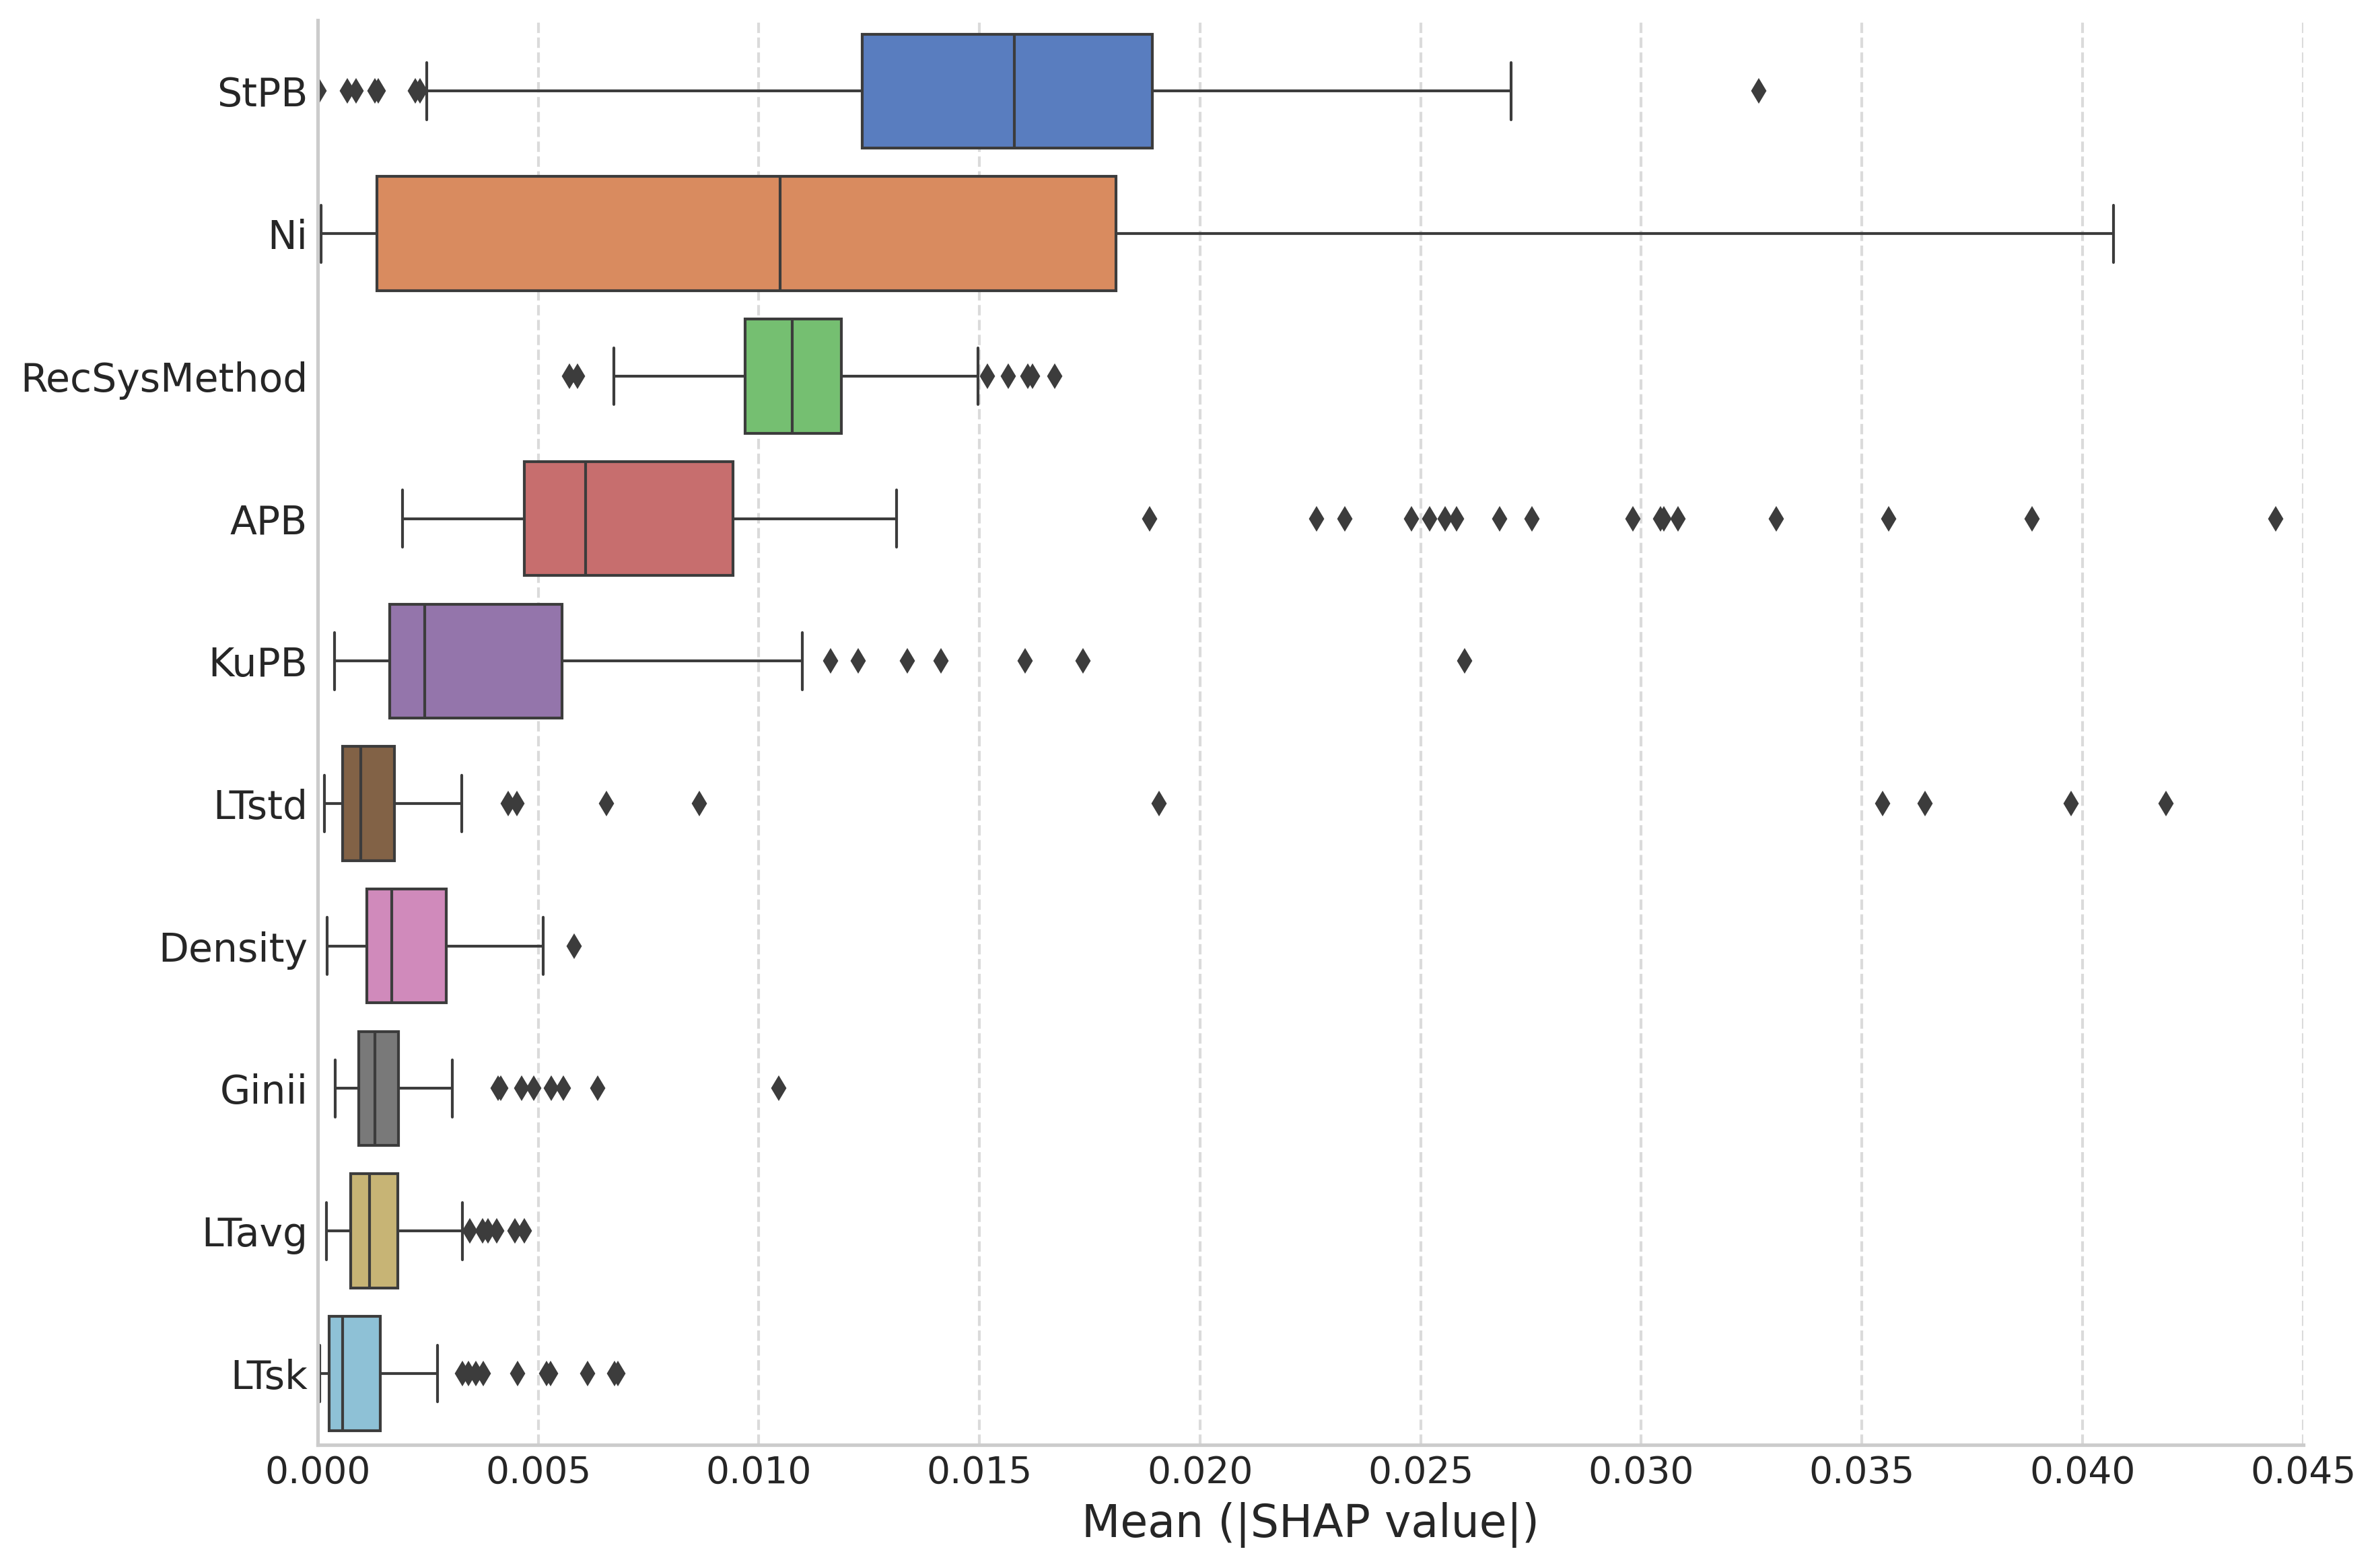

In [171]:
# Calculate the mean feature importance values and convert to a Pandas Series
mean_feature_importance = pd.DataFrame(feature_importance_list).mean()
# Sort features by mean importance in descending order
sorted_features = mean_feature_importance.sort_values(ascending=False)[:10]

# Create a DataFrame with feature importance values sorted by mean importance
sorted_feature_importance_df = pd.DataFrame({
    'Feature': sorted_features.index,
    'Mean Importance': sorted_features.values
})

# Set a scientific figure style using Seaborn
sns.set(style="whitegrid", font_scale=1.2)
sns.set_palette("viridis")

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

# Create a boxplot using Seaborn
sns.boxplot(data=pd.DataFrame(feature_importance_list)[sorted_features.index], orient='h', linewidth=1, palette="muted")

# Customize the plot
ax.set_xlabel('Mean (|SHAP value|)', fontsize=16)
# ax.set_ylabel('Top 10 Features', fontsize=16)
# ax.set_title('Boxplots of Feature Importance', fontsize=18)
ax.set_yticklabels(sorted_features.index, fontsize=14)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

# Save the figure as an image (optional)
plt.savefig(os.path.join("results", "datasets_statistics", "feature_importance_plot.pdf") , bbox_inches='tight')

# Show the plot
plt.xlim(0, 0.045)
plt.tight_layout()
plt.show()


In [172]:
# Calculate the mean feature importance across splits
mean_feature_importance = pd.DataFrame(feature_importance_list).mean()

# Calculate the standard deviation of feature importance across splits
std_feature_importance = pd.DataFrame(feature_importance_list).std()

# Combine mean and std into a single DataFrame
result_df = pd.concat([mean_feature_importance, std_feature_importance], axis=1)
result_df.columns = ['Mean Feature Importance', 'Std Feature Importance']

# Sort the values by mean feature importance
result_df = result_df.sort_values(by='Mean Feature Importance', ascending=False)

# Print the sorted DataFrame
print("Mean and Standard Deviation of Feature Importance Across Splits (Sorted by Mean):")
print(result_df)

Mean and Standard Deviation of Feature Importance Across Splits (Sorted by Mean):
              Mean Feature Importance  Std Feature Importance
StPB                         0.014624                0.006177
Ni                           0.011359                0.010328
RecSysMethod                 0.010862                0.002204
APB                          0.010735                0.010801
KuPB                         0.004275                0.004229
LTstd                        0.002929                0.007610
Density                      0.002051                0.001221
Ginii                        0.001684                0.001434
LTavg                        0.001439                0.000951
LTsk                         0.001158                0.001449
Rpi                          0.001049                0.001616
Shape                        0.000986                0.004221
SkPB                         0.000742                0.001188
Giniu                        0.000688             

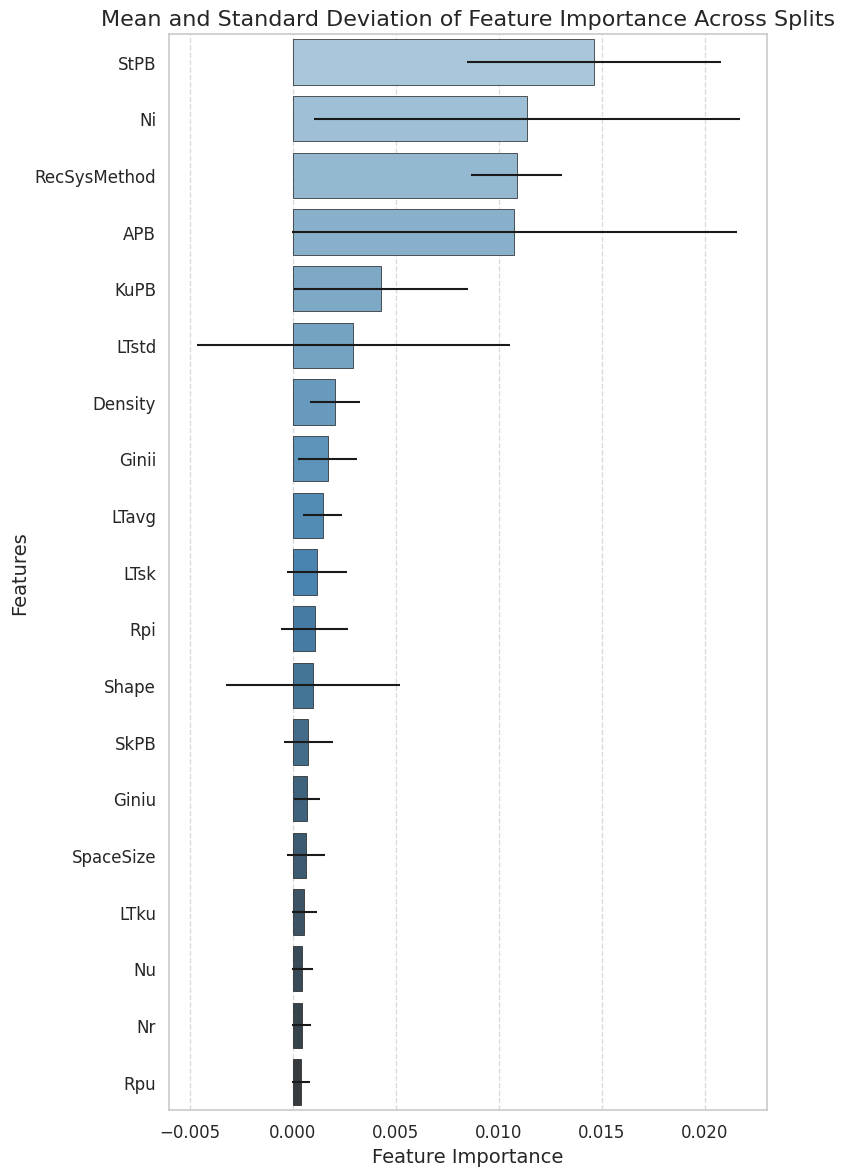

In [173]:
# Sort by Mean Feature Importance
result_df = result_df.sort_values(by='Mean Feature Importance', ascending=False)
# Plot
plt.figure(figsize=(8, 12))
# Barplot with modified aesthetics
sns.barplot(y=result_df.index, x=result_df['Mean Feature Importance'], xerr=result_df['Std Feature Importance'],
            orient='h', palette="Blues_d", edgecolor="k", linewidth=0.5, errwidth=1.2, capsize=0.3)

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Title and labels
plt.title('Mean and Standard Deviation of Feature Importance Across Splits', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Tight layout and display
plt.tight_layout()
plt.show()

In [174]:
# Initialize variables to store SHAP values and feature importances
shap_values_list = []
feature_importance_list = []

# Iterate through different random_state values
for random_state in range(100):
    # Split into training and testing sets
    train_datasets_rand, _ = train_test_split(X['Dataset'].unique(), test_size=0.3, random_state=random_state)

    train_df_rand = X[X['Dataset'].isin(train_datasets_rand)]

    X_train_rand = train_df_rand[train_df_rand.columns.difference(['Dataset', 'Method',])].astype(float)
    y_train_rand = X_train_rand.pop('Value')
    
    # Train an XGBoost regressor
    model_rand = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0)
    model_rand.fit(X_train_rand, y_train_rand)
    
    # Predict
    y_pred_rand = model_rand.predict(X_train_rand)
    
    # Calculate the R2 score for this split
    r2 = r2_score(y_pred_rand, y_train_rand)
    print(f"Random State {random_state}: R-squared (R2) Score: {r2}")
    spearman_corr_list = []
    num_of_methods = X['Method'].nunique()
    for i in range(len(y_pred_rand) // num_of_methods):
        spearman_corr, _ = scipy.stats.spearmanr(y_train_rand[i*num_of_methods:(i+1)*num_of_methods], y_pred_rand[i*num_of_methods:(i+1)*num_of_methods])
        spearman_corr_list.append(spearman_corr)
        
    print(f"Random State {random_state}: Mean Spearman Rank Correlation Coefficient: {np.mean(spearman_corr_list)}")
    
    # Use SHAP to interpret the model
    explainer = shap.Explainer(model_rand)
    shap_values = explainer(X_train_rand)
    shap_values_list.append(shap_values)
    
    # Calculate and store mean SHAP values as feature importances
    mean_shap_values = np.abs(shap_values.values).mean(axis=0)
    feature_importance = pd.Series(mean_shap_values, index=X_train_rand.columns).sort_values(ascending=False)
    feature_importance_list.append(feature_importance)

Random State 0: R-squared (R2) Score: 0.9968859155195667
Random State 0: Mean Spearman Rank Correlation Coefficient: 0.93734335839599


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:20:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 1: R-squared (R2) Score: 0.9989485370978847
Random State 1: Mean Spearman Rank Correlation Coefficient: 0.9661654135338344


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:21:14] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 2: R-squared (R2) Score: 0.997888530855709
Random State 2: Mean Spearman Rank Correlation Coefficient: 0.9235588972431079


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:21:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 3: R-squared (R2) Score: 0.9964128610067199
Random State 3: Mean Spearman Rank Correlation Coefficient: 0.9172932330827068


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:21:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 4: R-squared (R2) Score: 0.9982319239756365
Random State 4: Mean Spearman Rank Correlation Coefficient: 0.9436090225563911


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:22:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 5: R-squared (R2) Score: 0.9983255770495151
Random State 5: Mean Spearman Rank Correlation Coefficient: 0.9235588972431076


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:22:18] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 6: R-squared (R2) Score: 0.9988331360650695
Random State 6: Mean Spearman Rank Correlation Coefficient: 0.9223057644110276


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:22:34] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 7: R-squared (R2) Score: 0.9982432433585576
Random State 7: Mean Spearman Rank Correlation Coefficient: 0.9586466165413534


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:22:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 8: R-squared (R2) Score: 0.9992241823524419
Random State 8: Mean Spearman Rank Correlation Coefficient: 0.9523809523809523


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:23:07] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 9: R-squared (R2) Score: 0.9966204341739663
Random State 9: Mean Spearman Rank Correlation Coefficient: 0.918546365914787


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:23:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:23:23] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 10: R-squared (R2) Score: 0.9985874187318611
Random State 10: Mean Spearman Rank Correlation Coefficient: 0.9486215538847119


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:23:39] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 11: R-squared (R2) Score: 0.9990294812062297
Random State 11: Mean Spearman Rank Correlation Coefficient: 0.931077694235589


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:23:56] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 12: R-squared (R2) Score: 0.9989145968237875
Random State 12: Mean Spearman Rank Correlation Coefficient: 0.9611528822055136


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:24:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 13: R-squared (R2) Score: 0.9981538503865353
Random State 13: Mean Spearman Rank Correlation Coefficient: 0.968671679197995


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:24:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 14: R-squared (R2) Score: 0.9987913045773508
Random State 14: Mean Spearman Rank Correlation Coefficient: 0.9661654135338348


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:24:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 15: R-squared (R2) Score: 0.9988920821568157
Random State 15: Mean Spearman Rank Correlation Coefficient: 0.9273182957393484


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:24:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 16: R-squared (R2) Score: 0.9963771284272063
Random State 16: Mean Spearman Rank Correlation Coefficient: 0.9473684210526315


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:25:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 17: R-squared (R2) Score: 0.9985988193676332
Random State 17: Mean Spearman Rank Correlation Coefficient: 0.9273182957393484


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:25:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 18: R-squared (R2) Score: 0.9985277918797841
Random State 18: Mean Spearman Rank Correlation Coefficient: 0.9411027568922306


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:25:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 19: R-squared (R2) Score: 0.9977403374507117
Random State 19: Mean Spearman Rank Correlation Coefficient: 0.9385964912280703


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:26:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 20: R-squared (R2) Score: 0.9993220069058297
Random State 20: Mean Spearman Rank Correlation Coefficient: 0.9298245614035087


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:26:18] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 21: R-squared (R2) Score: 0.9988125010505658
Random State 21: Mean Spearman Rank Correlation Coefficient: 0.951127819548872


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:26:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 22: R-squared (R2) Score: 0.998361130552053
Random State 22: Mean Spearman Rank Correlation Coefficient: 0.931077694235589


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:26:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 23: R-squared (R2) Score: 0.9992657021315693
Random State 23: Mean Spearman Rank Correlation Coefficient: 0.9636591478696742


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:27:06] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 24: R-squared (R2) Score: 0.9988868398417734
Random State 24: Mean Spearman Rank Correlation Coefficient: 0.9210526315789473


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:27:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 25: R-squared (R2) Score: 0.9982654748074002
Random State 25: Mean Spearman Rank Correlation Coefficient: 0.9172932330827068


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:27:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 26: R-squared (R2) Score: 0.9983095882667902
Random State 26: Mean Spearman Rank Correlation Coefficient: 0.9398496240601504


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:27:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 27: R-squared (R2) Score: 0.9988187132522756
Random State 27: Mean Spearman Rank Correlation Coefficient: 0.9360902255639098


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:28:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 28: R-squared (R2) Score: 0.9979839709114829
Random State 28: Mean Spearman Rank Correlation Coefficient: 0.93734335839599


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:28:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 29: R-squared (R2) Score: 0.9991526091874706
Random State 29: Mean Spearman Rank Correlation Coefficient: 0.9473684210526315


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:28:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 30: R-squared (R2) Score: 0.9985415951952455
Random State 30: Mean Spearman Rank Correlation Coefficient: 0.951127819548872


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:28:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 31: R-squared (R2) Score: 0.9976398404718566
Random State 31: Mean Spearman Rank Correlation Coefficient: 0.9348370927318298


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:29:07] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 32: R-squared (R2) Score: 0.9974820328788075
Random State 32: Mean Spearman Rank Correlation Coefficient: 0.9122807017543859


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:29:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 33: R-squared (R2) Score: 0.997151145485925
Random State 33: Mean Spearman Rank Correlation Coefficient: 0.9235588972431079


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:29:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 34: R-squared (R2) Score: 0.9980679803303323
Random State 34: Mean Spearman Rank Correlation Coefficient: 0.9248120300751879


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:29:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 35: R-squared (R2) Score: 0.9992579875492191
Random State 35: Mean Spearman Rank Correlation Coefficient: 0.9598997493734337


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:30:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 36: R-squared (R2) Score: 0.9992034079220957
Random State 36: Mean Spearman Rank Correlation Coefficient: 0.9561403508771931


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:30:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 37: R-squared (R2) Score: 0.9986962230470059
Random State 37: Mean Spearman Rank Correlation Coefficient: 0.9223057644110276


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:30:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 38: R-squared (R2) Score: 0.9978019387099569
Random State 38: Mean Spearman Rank Correlation Coefficient: 0.9122807017543861


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:30:56] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 39: R-squared (R2) Score: 0.9984091449218992
Random State 39: Mean Spearman Rank Correlation Coefficient: 0.9586466165413533


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:31:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 40: R-squared (R2) Score: 0.9989591199424923
Random State 40: Mean Spearman Rank Correlation Coefficient: 0.9486215538847119


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:31:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 41: R-squared (R2) Score: 0.9981448500242266
Random State 41: Mean Spearman Rank Correlation Coefficient: 0.9461152882205512


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:31:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 42: R-squared (R2) Score: 0.9982094391528132
Random State 42: Mean Spearman Rank Correlation Coefficient: 0.9172932330827068


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:31:56] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 43: R-squared (R2) Score: 0.9984452466239478
Random State 43: Mean Spearman Rank Correlation Coefficient: 0.9426569453637662


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:32:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 44: R-squared (R2) Score: 0.9985438652584033
Random State 44: Mean Spearman Rank Correlation Coefficient: 0.951127819548872


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:32:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 45: R-squared (R2) Score: 0.99902031818379
Random State 45: Mean Spearman Rank Correlation Coefficient: 0.9298245614035089


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:32:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 46: R-squared (R2) Score: 0.9982885466466929
Random State 46: Mean Spearman Rank Correlation Coefficient: 0.9411027568922306


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:32:56] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 47: R-squared (R2) Score: 0.9974311322478809
Random State 47: Mean Spearman Rank Correlation Coefficient: 0.9523809523809523


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:33:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 48: R-squared (R2) Score: 0.9986410408177423
Random State 48: Mean Spearman Rank Correlation Coefficient: 0.935138148371285


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:33:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 49: R-squared (R2) Score: 0.9972680185623171
Random State 49: Mean Spearman Rank Correlation Coefficient: 0.9128903394242833


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:33:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 50: R-squared (R2) Score: 0.9985195200097415
Random State 50: Mean Spearman Rank Correlation Coefficient: 0.9310776942355892


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:33:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 51: R-squared (R2) Score: 0.9983563290543459
Random State 51: Mean Spearman Rank Correlation Coefficient: 0.9448621553884714


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:34:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 52: R-squared (R2) Score: 0.9986865936367505
Random State 52: Mean Spearman Rank Correlation Coefficient: 0.9498746867167922


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:34:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 53: R-squared (R2) Score: 0.9988430610850508
Random State 53: Mean Spearman Rank Correlation Coefficient: 0.9461152882205512


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:34:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 54: R-squared (R2) Score: 0.9984207571545552
Random State 54: Mean Spearman Rank Correlation Coefficient: 0.9561403508771928


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:34:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 55: R-squared (R2) Score: 0.9981704579731433
Random State 55: Mean Spearman Rank Correlation Coefficient: 0.9323308270676692


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:35:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 56: R-squared (R2) Score: 0.9990146956645777
Random State 56: Mean Spearman Rank Correlation Coefficient: 0.9624060150375939


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:35:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 57: R-squared (R2) Score: 0.9983072332930851
Random State 57: Mean Spearman Rank Correlation Coefficient: 0.9320090794865777


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:35:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 58: R-squared (R2) Score: 0.99873398372718
Random State 58: Mean Spearman Rank Correlation Coefficient: 0.9611528822055136


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:35:57] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 59: R-squared (R2) Score: 0.9986253973696317
Random State 59: Mean Spearman Rank Correlation Coefficient: 0.9448621553884712


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:36:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 60: R-squared (R2) Score: 0.9988098818396032
Random State 60: Mean Spearman Rank Correlation Coefficient: 0.9486215538847117


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:36:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 61: R-squared (R2) Score: 0.9988934945618674
Random State 61: Mean Spearman Rank Correlation Coefficient: 0.951127819548872


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:36:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 62: R-squared (R2) Score: 0.9987626104021318
Random State 62: Mean Spearman Rank Correlation Coefficient: 0.9436090225563911


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:36:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 63: R-squared (R2) Score: 0.9984787586892806
Random State 63: Mean Spearman Rank Correlation Coefficient: 0.9573934837092731


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:37:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 64: R-squared (R2) Score: 0.99836655992788
Random State 64: Mean Spearman Rank Correlation Coefficient: 0.951127819548872


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:37:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 65: R-squared (R2) Score: 0.9984833737764433
Random State 65: Mean Spearman Rank Correlation Coefficient: 0.9285714285714287


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:37:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 66: R-squared (R2) Score: 0.9983279558631498
Random State 66: Mean Spearman Rank Correlation Coefficient: 0.9436090225563911


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:37:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 67: R-squared (R2) Score: 0.9980932755722056
Random State 67: Mean Spearman Rank Correlation Coefficient: 0.9197994987468673


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:38:14] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 68: R-squared (R2) Score: 0.9990510050329534
Random State 68: Mean Spearman Rank Correlation Coefficient: 0.9285714285714287


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:38:29] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 69: R-squared (R2) Score: 0.9990254748875439
Random State 69: Mean Spearman Rank Correlation Coefficient: 0.9649122807017545


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:38:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 70: R-squared (R2) Score: 0.997969391228853
Random State 70: Mean Spearman Rank Correlation Coefficient: 0.9423558897243108


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:39:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 71: R-squared (R2) Score: 0.9989576707447579
Random State 71: Mean Spearman Rank Correlation Coefficient: 0.9624060150375939


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:39:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 72: R-squared (R2) Score: 0.9981887074928889
Random State 72: Mean Spearman Rank Correlation Coefficient: 0.9122807017543861


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:39:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 73: R-squared (R2) Score: 0.9976122538164036
Random State 73: Mean Spearman Rank Correlation Coefficient: 0.9160401002506265


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:39:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:39:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 74: R-squared (R2) Score: 0.9985598214140929
Random State 74: Mean Spearman Rank Correlation Coefficient: 0.9523809523809523


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:40:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 75: R-squared (R2) Score: 0.9987454919701718
Random State 75: Mean Spearman Rank Correlation Coefficient: 0.9436090225563911


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:40:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 76: R-squared (R2) Score: 0.9974826552226173
Random State 76: Mean Spearman Rank Correlation Coefficient: 0.9411027568922307


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:40:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 77: R-squared (R2) Score: 0.9975123376430121
Random State 77: Mean Spearman Rank Correlation Coefficient: 0.931077694235589


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:40:46] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 78: R-squared (R2) Score: 0.9979677573538661
Random State 78: Mean Spearman Rank Correlation Coefficient: 0.9548872180451129


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:41:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 79: R-squared (R2) Score: 0.997642704426381
Random State 79: Mean Spearman Rank Correlation Coefficient: 0.9235588972431078


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:41:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 80: R-squared (R2) Score: 0.9992397936135115
Random State 80: Mean Spearman Rank Correlation Coefficient: 0.9699248120300753


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:41:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 81: R-squared (R2) Score: 0.9970495998999128
Random State 81: Mean Spearman Rank Correlation Coefficient: 0.9260651629072681


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:41:46] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 82: R-squared (R2) Score: 0.9987720444268753
Random State 82: Mean Spearman Rank Correlation Coefficient: 0.9649122807017545


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:42:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 83: R-squared (R2) Score: 0.9986847302655913
Random State 83: Mean Spearman Rank Correlation Coefficient: 0.9573934837092731


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:42:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 84: R-squared (R2) Score: 0.9972294366439524
Random State 84: Mean Spearman Rank Correlation Coefficient: 0.9335839598997495


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:42:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 85: R-squared (R2) Score: 0.9983646652008606
Random State 85: Mean Spearman Rank Correlation Coefficient: 0.9436090225563911


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:42:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 86: R-squared (R2) Score: 0.9984571512845186
Random State 86: Mean Spearman Rank Correlation Coefficient: 0.9423558897243108


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:43:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 87: R-squared (R2) Score: 0.9984899716003275
Random State 87: Mean Spearman Rank Correlation Coefficient: 0.9536340852130325


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:43:19] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 88: R-squared (R2) Score: 0.9992968699833024
Random State 88: Mean Spearman Rank Correlation Coefficient: 0.9498746867167922


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:43:34] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 89: R-squared (R2) Score: 0.9964485339086583
Random State 89: Mean Spearman Rank Correlation Coefficient: 0.929824561403509


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:43:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 90: R-squared (R2) Score: 0.9984837543744464
Random State 90: Mean Spearman Rank Correlation Coefficient: 0.9536340852130326


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:44:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 91: R-squared (R2) Score: 0.9983760162381826
Random State 91: Mean Spearman Rank Correlation Coefficient: 0.949874686716792


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:44:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 92: R-squared (R2) Score: 0.9986052922652487
Random State 92: Mean Spearman Rank Correlation Coefficient: 0.9323308270676692


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:44:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 93: R-squared (R2) Score: 0.9980407783105041
Random State 93: Mean Spearman Rank Correlation Coefficient: 0.9010025062656642


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:44:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 94: R-squared (R2) Score: 0.9987370752557051
Random State 94: Mean Spearman Rank Correlation Coefficient: 0.9436090225563911


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:44:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 95: R-squared (R2) Score: 0.9989033127680468
Random State 95: Mean Spearman Rank Correlation Coefficient: 0.93734335839599


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:45:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 96: R-squared (R2) Score: 0.9972907971985263
Random State 96: Mean Spearman Rank Correlation Coefficient: 0.9461152882205512


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:45:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 97: R-squared (R2) Score: 0.9971098928007229
Random State 97: Mean Spearman Rank Correlation Coefficient: 0.9411027568922307


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:45:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 98: R-squared (R2) Score: 0.9978321715503803
Random State 98: Mean Spearman Rank Correlation Coefficient: 0.9235588972431079


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:45:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Random State 99: R-squared (R2) Score: 0.996388870527457
Random State 99: Mean Spearman Rank Correlation Coefficient: 0.8959899749373434


/home/user/conda/envs/recsys/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:46:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [175]:
# Calculate the mean feature importance across splits
mean_feature_importance = pd.DataFrame(feature_importance_list).mean()

# Calculate the standard deviation of feature importance across splits
std_feature_importance = pd.DataFrame(feature_importance_list).std()

# Combine mean and std into a single DataFrame
result_df = pd.concat([mean_feature_importance, std_feature_importance], axis=1)
result_df.columns = ['Mean Feature Importance', 'Std Feature Importance']

# Sort the values by mean feature importance
result_df = result_df.sort_values(by='Mean Feature Importance', ascending=False)

# Print the sorted DataFrame
print("Mean and Standard Deviation of Feature Importance Across Splits (Sorted by Mean):")
print(result_df)

Mean and Standard Deviation of Feature Importance Across Splits (Sorted by Mean):
              Mean Feature Importance  Std Feature Importance
APB                          0.015200                0.010231
StPB                         0.013267                0.007241
RecSysMethod                 0.012358                0.002027
Ni                           0.007749                0.011253
KuPB                         0.005395                0.005354
Density                      0.002070                0.002214
Ginii                        0.002049                0.001536
LTstd                        0.002015                0.005788
LTavg                        0.001687                0.002672
LTsk                         0.001447                0.002633
Shape                        0.000908                0.002819
Giniu                        0.000890                0.000902
SpaceSize                    0.000815                0.001920
Rpi                          0.000629             

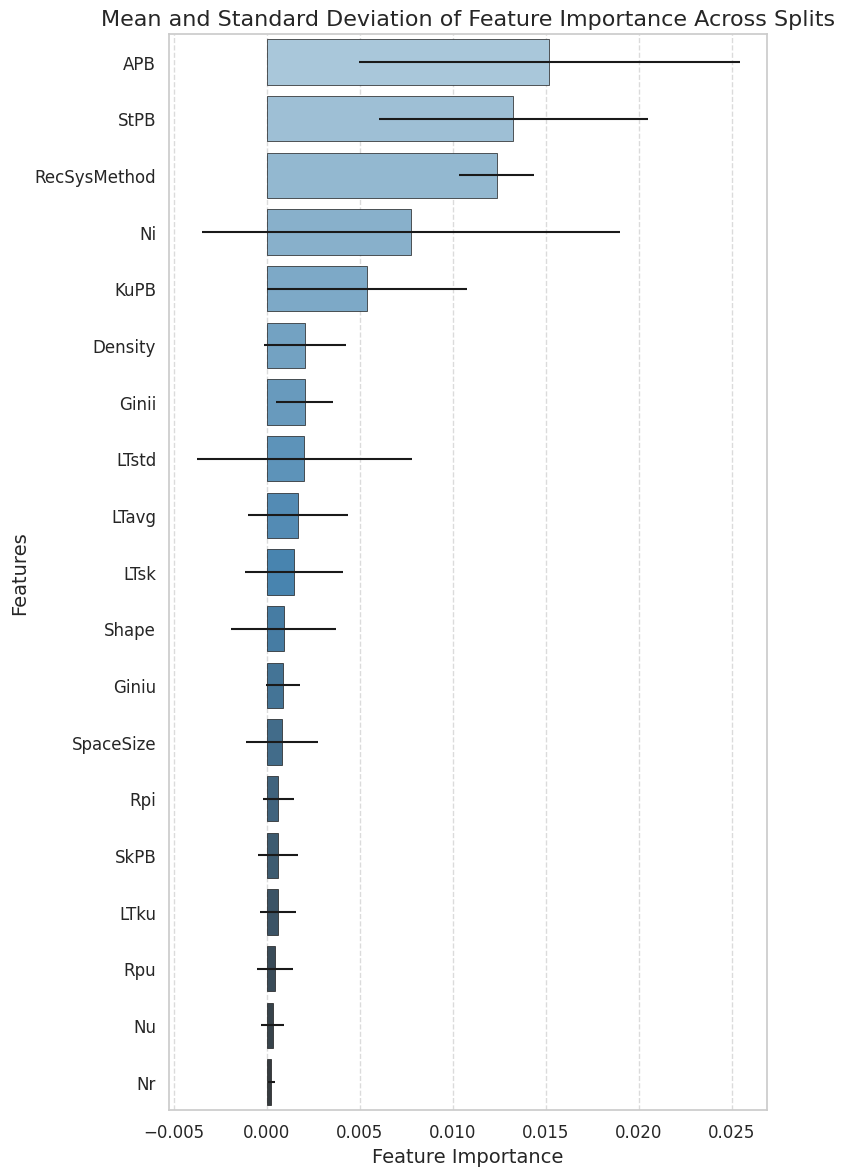

In [176]:
# Sort by Mean Feature Importance
result_df = result_df.sort_values(by='Mean Feature Importance', ascending=False)
# Plot
plt.figure(figsize=(8, 12))
# Barplot with modified aesthetics
sns.barplot(y=result_df.index, x=result_df['Mean Feature Importance'], xerr=result_df['Std Feature Importance'],
            orient='h', palette="Blues_d", edgecolor="k", linewidth=0.5, errwidth=1.2, capsize=0.3)

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Title and labels
plt.title('Mean and Standard Deviation of Feature Importance Across Splits', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Tight layout and display
plt.tight_layout()
plt.show()

R-squared (R2) Score: 0.9991126763852914
Mean Spearman Rank Correlation Coefficient: 0.9450549450549451


[19:00:15] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


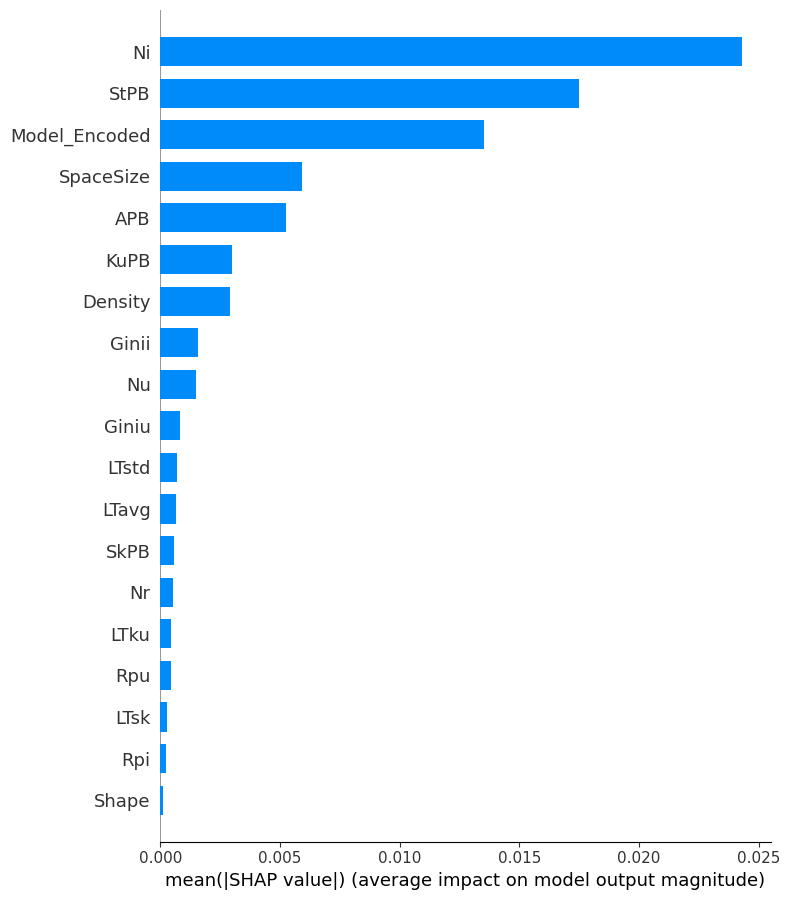

In [ ]:
y_train = X['Value']
X_train = X[X.columns.difference(['Dataset', 'Method','Value'])].astype(float)

# Train an XGBoost regressor
model = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=1)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_train)
from sklearn.metrics import r2_score
# Calculate the R2 score
r2 = r2_score(y_train, y_pred)

print("R-squared (R2) Score:", r2)
import scipy.stats
# Calculate Mean Spearman Rank Correlation Coefficient:
spearman_corr_list = []
num_of_methods = X['Method'].nunique()
for i in range(len(y_pred) // X['Method'].nunique()):
    spearman_corr, _ = scipy.stats.spearmanr(y_train[i*num_of_methods:(i+1)*num_of_methods], y_pred[i*num_of_methods:(i+1)*num_of_methods])
    spearman_corr_list.append(spearman_corr)
    
print("Mean Spearman Rank Correlation Coefficient:", np.mean(spearman_corr_list))
# Use SHAP to interpret the model
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


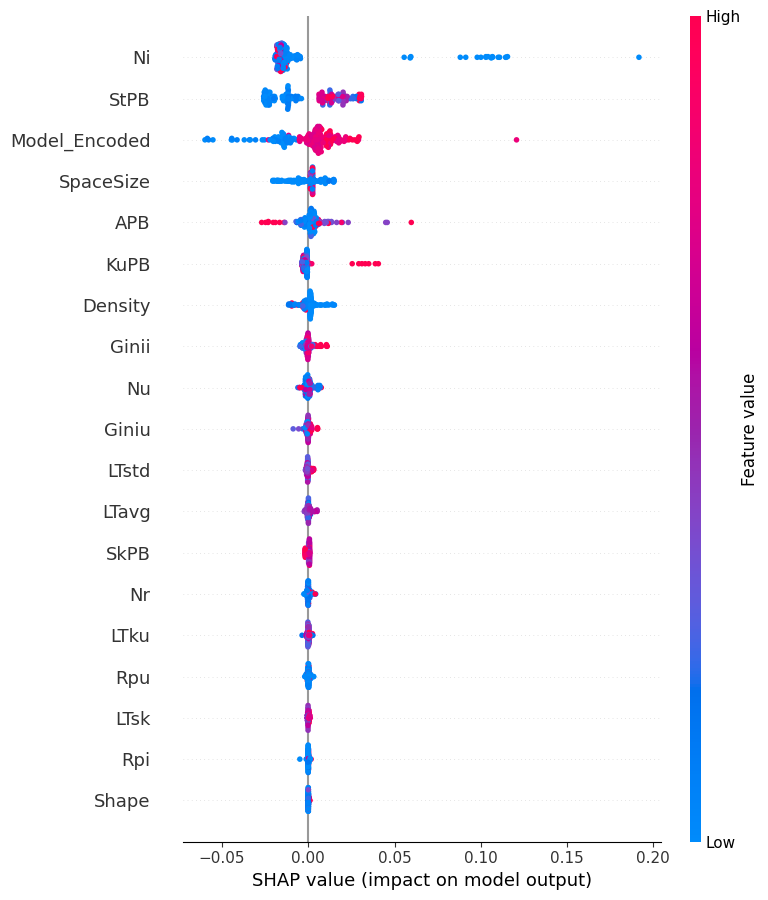

In [ ]:
# Plot feature importance
shap.summary_plot(shap_values, X_train)
mean_shap_values = np.abs(shap_values.values).mean(axis=0)


In [ ]:
feature_importance = pd.Series(mean_shap_values, index=X_train.columns).sort_values(ascending=False)
print(feature_importance)

Ni               0.024292
StPB             0.017500
Model_Encoded    0.013545
SpaceSize        0.005937
APB              0.005269
KuPB             0.002995
Density          0.002930
Ginii            0.001571
Nu               0.001490
Giniu            0.000823
LTstd            0.000691
LTavg            0.000639
SkPB             0.000557
Nr               0.000547
LTku             0.000448
Rpu              0.000447
LTsk             0.000282
Rpi              0.000241
Shape            0.000126
dtype: float32
